
# Project 4: Churn Prediction Modelling 

---

In [3]:
import pandas as pd

data = r"/Users/meisan/Documents/GitHub/GA-DAT9-Projects1/R_Morgan_Project4_Files/telecom_data.csv"
df = pd.read_csv(data)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

% matplotlib inline

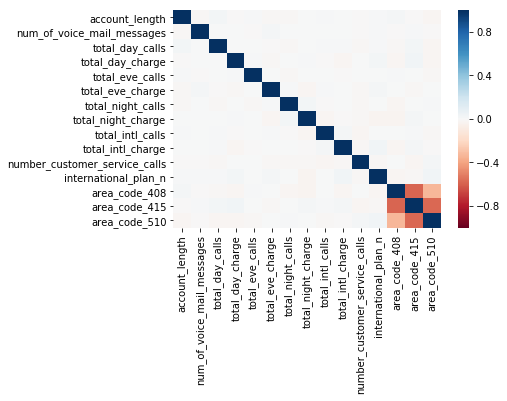

In [5]:
feature_names = ['account_length','num_of_voice_mail_messages','total_day_calls','total_day_charge',
                 'total_eve_calls','total_eve_charge','total_night_calls','total_night_charge',
                 'total_intl_calls','total_intl_charge','number_customer_service_calls','international_plan_n',
                 'area_code_408','area_code_415','area_code_510']

predictors = ['account_length','total_intl_charge','number_customer_service_calls',
              'total_day_calls','area_code_408','area_code_415','area_code_510']

X = df[feature_names]
y = df['churn_n']

sns.heatmap(X.corr(),vmin=-1,vmax=1,center=0,cmap='RdBu')

In [6]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = ss.fit_transform(X)

#### Use Smote-Tomek to resample data

In [7]:
from collections import Counter
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=123)
X_res, y_res = smt.fit_sample(Xs, y)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))
X_samp = pd.DataFrame(X_res, columns = feature_names)
y_samp = pd.DataFrame(y_res, columns = ['churn_n'])

Original dataset shape Counter({0: 4293, 1: 707})
Resampled dataset shape Counter({0: 4292, 1: 4292})


In [8]:
X_samp.head()

,account_length,num_of_voice_mail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_n,area_code_408,area_code_415,area_code_510
0,0.698941,1.273145,0.502824,1.574074,-0.060077,-0.063849,-0.446928,0.876286,-0.584236,-0.095509,-0.436676,-0.323240,-0.580122,1.002002,-0.576119
1,0.169849,1.346973,1.158422,-0.347082,0.141693,-0.101089,0.154374,1.069818,-0.584236,1.245982,-0.436676,-0.323240,-0.580122,1.002002,-0.576119
2,0.925695,-0.572549,0.704546,1.171286,0.494791,-1.572084,0.204483,-0.746737,0.229917,0.695971,-1.202236,-0.323240,-0.580122,1.002002,-0.576119
3,-0.409634,-0.572549,-1.463971,2.210457,-0.614946,-2.745155,-0.547145,-0.069377,1.044069,-1.329681,0.328885,3.093675,1.723777,-0.998002,-0.576119
4,-0.636388,-0.572549,0.654116,-0.252115,1.100103,-1.034426,1.056327,-0.267307,-0.584236,-0.055264,1.094445,3.093675,-0.580122,1.002002,-0.576119


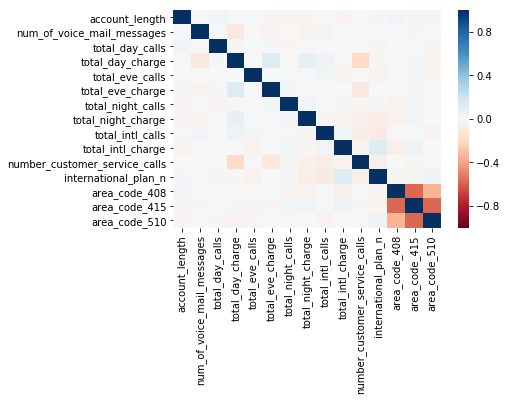

In [9]:
#get visual distributions of all metrics
sns.heatmap(X_samp.corr(),vmin=-1,vmax=1,center=0,cmap='RdBu')

1. CRIM, ZN and RM do not have strong correlation, so we can use them as model features.

### Logisitic Regression Modelling

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# create training and testing vars, check shape
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2,random_state=123)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(6867, 15) (6867,)
(1717, 15) (1717,)


In [11]:
# Make an instance of a LinearRegression object.
lr = LogisticRegression()
type(lr)

sklearn.linear_model.logistic.LogisticRegression

In [12]:
model = lr.fit(X_train, y_train)
print(lr.intercept_)
print(lr.coef_)

[-0.68334051]
[[ 0.06034927 -0.46044573  0.04311776  0.77387899 -0.01223031  0.43202967
  -0.06308781  0.25381826 -0.1568363   0.23789095  0.87602113  0.71344466
   0.02847505 -0.03032511  0.00648021]]


In [13]:
#assign array with predicted 'y' results to 'y_predicted'
y_pred = lr.predict(X_test)
y_pred

array([0, 1, 1, ..., 1, 0, 1])

In [14]:
y_pred_prob = lr.predict_proba(X_test)[:, 1]

In [15]:
from sklearn import metrics
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred > .5)

array([[660, 183],
       [192, 682]])

In [16]:
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.8555217146998706

In [17]:
#print accuracy score of model
print('Test Score:', model.score(X_test,y_test))
print('Train Score:', model.score(X_train,y_train))

Test Score: 0.7815958066394875
Train Score: 0.7849133537206932


### Elastic Net Regularisation

In [18]:
from sklearn.linear_model import SGDClassifier
#alpha = i for i in range(0.1,1,0.1)
clf = SGDClassifier(penalty='elasticnet',alpha=0.5,max_iter=1000, loss = 'log',random_state=123)
clf_model = clf.fit(X_train, y_train)
print(clf.intercept_)
print(clf.coef_)

[-0.0893312]
[[0.         0.         0.         0.10447024 0.         0.
  0.         0.         0.         0.         0.10094906 0.14062813
  0.         0.         0.        ]]


#### Feature removal

elastic net feature removal retained the following features:

__1. 'num_of_voice_mail_messages'__

__2. 'total_day_charge'__

__3. 'number_customer_service_calls'__

__4. 'international_plan_n'__

In [19]:
predicted_enet = clf.predict_proba(X_test)

In [20]:
preds = predicted_enet[:,1]
fpr_enet, tpr_enet, threshold_enet = metrics.roc_curve(y_test, preds)
roc_auc_enet = metrics.auc(fpr_enet, tpr_enet)
roc_auc_enet

0.8316455885187206

In [21]:
#performs worse with elasticnet
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_prob > .5)

array([[660, 183],
       [192, 682]])

In [22]:
print('Training Score:', clf_model.score(X_train,y_train))
print('Test Score:', clf_model.score(X_test,y_test))

Training Score: 0.7164700742682394
Test Score: 0.7350029120559115


### Re-fit

In [23]:
#re-fit model with isolated features from elasticnet
ss = StandardScaler()
Xs = ss.fit_transform(X)

enet_predictors = ['num_of_voice_mail_messages','total_day_charge',
                   'number_customer_service_calls','international_plan_n']
#assign enet predictors to balanced X data
X_samp_f = X_samp[enet_predictors]

#split data
X_train, X_test, y_train, y_test = train_test_split(X_samp_f, y_res, test_size=0.2,random_state=123)


lr = LogisticRegression()
model_2 = lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

probs = model_2.predict_proba(X_test)
preds = probs[:,1]
fpr_2, tpr_2, threshold_2 = metrics.roc_curve(y_test, preds)
roc_auc_2 = metrics.auc(fpr_2, tpr_2)
roc_auc_2

0.8432528210515458

In [24]:
#print accuracy score of model
print('Test Score:', model_2.score(X_test,y_test))
print('Training Score:', model_2.score(X_train,y_train))

Test Score: 0.7716948165404776
Training Score: 0.762487257900102


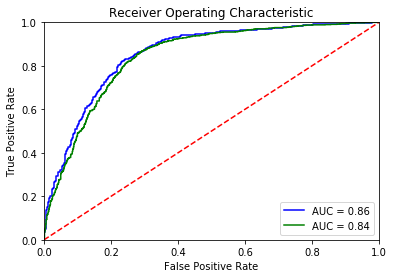

In [25]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr_2, tpr_2, 'g', label = 'AUC = %0.2f' % roc_auc_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [46]:
from feature_selector import FeatureSelector

fs = FeatureSelector(data = X_samp, labels = y_samp)

fs.identify_missing(missing_threshold=0.6)
missing_features = fs.ops['missing']
missing_features[:10]

0 features with greater than 0.60 missing values.



[]

In [27]:
fs.identify_collinear(correlation_threshold=0.975)
correlated_features = fs.ops['collinear']
correlated_features[:5]

0 features with a correlation magnitude greater than 0.97.



[]

In [28]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[488]	valid_0's auc: 0.996971	valid_0's binary_logloss: 0.0696065
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[527]	valid_0's auc: 0.993969	valid_0's binary_logloss: 0.0820424
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[596]	valid_0's auc: 0.993313	valid_0's binary_logloss: 0.0992322
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[617]	valid_0's auc: 0.996684	valid_0's binary_logloss: 0.0645057
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[466]	valid_0's auc: 0.995853	valid_0's binary_logloss: 0.0790061
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[454]	valid_0's auc: 0.993358	valid_0's binary_l

In [29]:
fs.identify_low_importance(cumulative_importance = 0.99)
low_importance_features = fs.ops['low_importance']
low_importance_features[:5]

13 features required for cumulative importance of 0.99 after one hot encoding.
2 features do not contribute to cumulative importance of 0.99.



['area_code_408', 'area_code_510']

In [30]:
#create probability / odds table for later use
#lo_table = pd.DataFrame({'Probability':list(y_pred_prob),'Odds':list(y_pred_prob/(1-y_pred_prob))})
#lo_table.shape

(1717, 2)

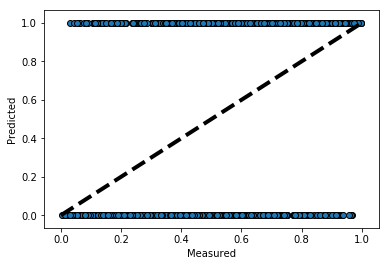

In [31]:
fig, ax = plt.subplots()
ax.scatter(y_pred_prob, y_test, edgecolors=(0,0,0))
ax.plot([y.min(),y.max()],[y.min(),y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### K-fold cross validation

In [47]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import metrics

scores = []
no_folds = []
for n in range(2,51):
    predicted = cross_val_predict(model, X_res, y_res, cv=n)
    score = metrics.accuracy_score(y_res, predicted)
    no_folds.append(n)
    scores.append(score)

no_folds    13.000000
scores       0.785182
Name: 11, dtype: float64


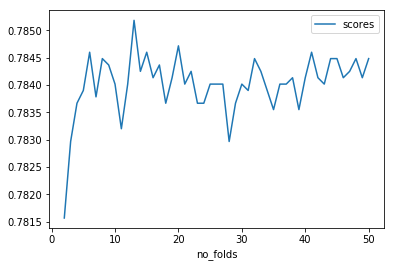

In [48]:
s = {'no_folds':no_folds, 'scores':scores}
n_scores = pd.DataFrame(s)
print(n_scores.iloc[n_scores['scores'].values.argmax()])
n_scores.plot('no_folds', 'scores')

In [35]:
from nltk import ConfusionMatrix 
print (ConfusionMatrix(list(y_res), list(predicted)))

  |    0    1 |
--+-----------+
0 |<3322> 970 |
1 |  880<3412>|
--+-----------+
(row = reference; col = test)



In [36]:
scores = []
for n in range(2,51):
    scores = cross_val_score(model, X_test, y_test, cv=n)
    print('--------{0}-fold stats --------'.format(n))
    print ('Cross-validated scores:', scores)
    print ('mean of {0}-fold CV scores: {1}'.format(n,np.mean(scores)))
    print("Variance of {0}-fold Cross validation: {1}".format(n,np.var(scores)))
    print('')

--------2-fold stats --------
Cross-validated scores: [0.774156   0.77622378]
mean of 2-fold CV scores: 0.7751898857835995
Variance of 2-fold Cross validation: 1.068929442289021e-06

--------3-fold stats --------
Cross-validated scores: [0.77661431 0.76223776 0.77097902]
mean of 3-fold CV scores: 0.7699436979541692
Variance of 3-fold Cross validation: 3.498347090397373e-05

--------4-fold stats --------
Cross-validated scores: [0.75581395 0.79534884 0.77389277 0.76635514]
mean of 4-fold CV scores: 0.772852676194341
Variance of 4-fold Cross validation: 0.00020992377731300873

--------5-fold stats --------
Cross-validated scores: [0.75       0.80523256 0.77034884 0.77842566 0.76900585]
mean of 5-fold CV scores: 0.774602579855746
Variance of 5-fold Cross validation: 0.00032150323014822616

--------6-fold stats --------
Cross-validated scores: [0.74912892 0.82926829 0.75609756 0.78671329 0.76140351 0.76842105]
mean of 6-fold CV scores: 0.7751721036059932
Variance of 6-fold Cross validation

--------29-fold stats --------
Cross-validated scores: [0.80327869 0.78688525 0.65       0.81666667 0.72881356 0.77966102
 0.81355932 0.86440678 0.83050847 0.84745763 0.77966102 0.71186441
 0.83050847 0.71186441 0.81355932 0.76271186 0.74576271 0.76271186
 0.84745763 0.83050847 0.81355932 0.72881356 0.77966102 0.74576271
 0.86440678 0.69491525 0.66101695 0.76271186 0.88135593]
mean of 29-fold CV scores: 0.7810362393129636
Variance of 29-fold Cross validation: 0.0035386371330382634

--------30-fold stats --------
Cross-validated scores: [0.79661017 0.77966102 0.69491525 0.77586207 0.75438596 0.78947368
 0.78947368 0.85964912 0.80701754 0.84210526 0.8245614  0.68421053
 0.8245614  0.73684211 0.78947368 0.85964912 0.70175439 0.75438596
 0.73684211 0.89473684 0.80701754 0.71929825 0.73684211 0.80701754
 0.75438596 0.85964912 0.68421053 0.66666667 0.75438596 0.87719298]
mean of 30-fold CV scores: 0.7787612661109231
Variance of 30-fold Cross validation: 0.0036210658455647

--------31-fold st

--------45-fold stats --------
Cross-validated scores: [0.74358974 0.79487179 0.84615385 0.69230769 0.66666667 0.82051282
 0.74358974 0.76923077 0.82051282 0.76923077 0.79487179 0.8974359
 0.84615385 0.79487179 0.84615385 0.87179487 0.64102564 0.69230769
 0.84615385 0.78947368 0.65789474 0.84210526 0.81578947 0.89473684
 0.65789474 0.68421053 0.76315789 0.84210526 0.84210526 0.86842105
 0.76315789 0.78947368 0.81578947 0.64864865 0.78378378 0.81081081
 0.72972973 0.86486486 0.81081081 0.67567568 0.7027027  0.64864865
 0.81081081 0.75675676 0.89189189]
mean of 45-fold CV scores: 0.779086373823216
Variance of 45-fold Cross validation: 0.005465038637051476

--------46-fold stats --------
Cross-validated scores: [0.73684211 0.81578947 0.81578947 0.78947368 0.55263158 0.84210526
 0.76315789 0.76315789 0.81578947 0.76315789 0.78947368 0.86842105
 0.89473684 0.76315789 0.86842105 0.89189189 0.7027027  0.75675676
 0.7027027  0.86486486 0.72972973 0.72972973 0.78378378 0.86486486
 0.78378378 0.

In [37]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
#predicted = cross_val_predict(lr, y_predicted, y_test, cv=10, random_state=123)


#fig, ax = plt.subplots()
#ax.scatter(y_test, predicted, edgecolors=(0,0,0))
#ax.plot([y.min(),y.max()],[y.min(),y.max()], 'k--', lw=4)
#ax.set_xlabel('Measured')
#ax.set_ylabel('Predicted')
#plt.show()

### KNN Model

In [ ]:
# Increase the default figure and font sizes for easier viewing
import matplotlib.ticker as ticker

plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['font.size'] = 14
plt.rcParams["xtick.labelsize"] = 7
plt.rcParams["ytick.labelsize"] = 7

In [ ]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

In [ ]:
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
df.plot(kind='scatter', x='total_intl_charge', y='number_customer_service_calls', c='churn_n', colormap=cmap_bold);

### KNN Classification 

knn_acc            0.868957
num_neighbours    13.000000
Name: 11, dtype: float64


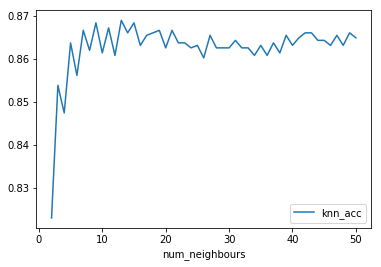

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#looped function for calculating accuracy for various neighbours
knn_acc = []
num_neighbours = []

for n in range(2,51):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    predicted_knn = knn.predict(X_test)
    knn_acc.append(accuracy_score(y_test, predicted_knn))
    num_neighbours.append(n)
    
s = {'knn_acc':knn_acc, 'num_neighbours':num_neighbours}
knn_scores = pd.DataFrame(s)
print(knn_scores.iloc[knn_scores['knn_acc'].values.argmax()])
knn_scores.plot('num_neighbours', 'knn_acc')
    


Optimal number of neigbours is 13. We will use n = 13 for computing ROC & AUC.

In [41]:
knn_13 = KNeighborsClassifier(n_neighbors=13)
knn_model = knn.fit(X_train, y_train)
predicted_knn = knn.predict_proba(X_test)
preds = predicted_knn[:,1]
fpr_knn, tpr_knn, threshold_knn = metrics.roc_curve(y_test, preds)
roc_auc_knn = metrics.auc(fpr_knn, tpr_knn)
roc_auc_knn

0.9231373730628598

In [45]:
#cross-validate all models with optimal number of folds - 13 folds.
print(cross_val_score(knn_model, X_res, y_res, cv=13, scoring='roc_auc').mean())
print(cross_val_score(model, X_res, y_res, cv=13, scoring='roc_auc').mean())
print(cross_val_score(model_2, X_samp_f, y_res, cv=13, scoring='roc_auc').mean()) 
print(cross_val_score(clf_model, X, y, cv=13, scoring='roc_auc').mean())

0.9304754192104038
0.8417751027870172
0.8255785348781655
0.6432703981436015


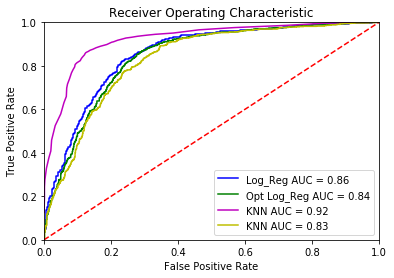

In [44]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'Log_Reg AUC = %0.2f' % roc_auc)
plt.plot(fpr_2, tpr_2, 'g', label = 'Opt Log_Reg AUC = %0.2f' % roc_auc_2)
plt.plot(fpr_knn, tpr_knn, 'm', label = 'KNN AUC = %0.2f' % roc_auc_knn)
plt.plot(fpr_enet, tpr_enet, 'y', label = 'KNN AUC = %0.2f' % roc_auc_enet)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#looped function for calculating accuracy for various neighbours
def get_knn(n):
    for n in range(1,n+1):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train, y_train)
        predicted_knn = knn.predict(X_test)
        acc = accuracy_score(y_test, predicted_knn)
        print('model accuracy for {0} neighbours is {1}'.format(n, acc))

get_knn(10)

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [ ]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

In [ ]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

In [ ]:
from sklearn.linear_model import ElasticNet

X = pd.DataFrame(boston.data,columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['MEDV'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

alpha = 0.4
enet = ElasticNet(alpha=alpha, l1_ratio=1)
enet_model = enet.fit(X_train, y_train)

print(enet.intercept_)
print(enet.coef_)

I'm choosing to optimise the score by using elastic net, in conjunction with linear regression for predicting MEDV.

1. Fitted an elastic net regression model for all boston features, setting Alpha to 0.4 and l1_ratio to 1 (LASSO).
2. Printed intercept and coefficients to determine removed features
3. By my estimation, features removed correspond to INDUS, CHAS, NOX and AGE.

I played around with the 'alpha' value, arriving at 0.4 as optimal.

In [ ]:
print('Training Score:', enet_model.score(X_train,y_train))
print('Test Score:', enet_model.score(X_test,y_test))

1. Compared Accuracies, less than 10% difference - indicates overfitting.

In [ ]:
for n in range(5,11):
    scores = cross_val_score(enet, X_test, y_test, scoring="r2", cv=n)
    print('-------- {0}-fold ENet stats --------'.format(n))
    print ('Cross-validated ENet scores:', scores)
    print ('mean of {0}-fold ENet CV scores: {1}'.format(n,np.mean(scores)))
    #print("Variance of {0}-fold Cross validation: {1}".format(n,np.var(scores)))
    print('')

1. 8 Fold elastic net model appears to have the highest R2 score. From interpretation against initial R2 score from statsmodel, there doesn't seem to be an improvement.